## Try out model from TempoBert
I think the `test_bert` module only works with the 'old' [tempobert](https://github.com/guyrosin/tempobert/) model, where the sentence was prepended with a token. The model [linked on github](https://github.com/guyrosin/temporal_attention/issues/1) is of type "attention_double_time". The tokenizer needs an extra argurment `time_id` which can take 2 values.


In [2]:
from bert_model import BertModel
from train_tempobert import ModelArguments
from transformers import AutoModelForMaskedLM, pipeline

from tqdm import tqdm

C:\Users\DafnevanKuppevelt\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import test_bert
import hf_utils

Load the model:

In [4]:
hf_utils.prepare_tf_classes()
model_name = 'temp_att_model_semeval_eng'
model_args = ModelArguments(model_name_or_path=model_name)
config_kwargs = {}
model, tokenizer = hf_utils.load_pretrained_model(
    model_args,
    AutoModelForMaskedLM,
    expect_times_in_model=True,
    **config_kwargs,
)

In [5]:
tokenizer

PreTrainedTokenizerFast(name_or_path='temp_att_model_semeval_eng', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

We create a pipeline, but automatically calling the pipeline doesn't work because the tokenizer encoding function needs an extra argument `time_id`, so we create a manual function.

In [6]:
fill_mask_pipeline = pipeline("fill-mask", model=model, tokenizer=tokenizer)

In [7]:
def run_pipeline(pipeline, sentences, time_id):
    if type(sentences)==str:
        encoded_inputs = pipeline.tokenizer.encode_plus(sentences, time_id=time_id, return_tensors='pt')
    else:
        encoded_inputs = pipeline.tokenizer.batch_encode_plus(sentences, batch_time_id=time_id*len(sentences), return_tensors='pt', padding=True)
    output = pipeline.forward(encoded_inputs)
    result = pipeline.postprocess(output)
    return result

In [8]:
sentence = "It is a national characteristic of the Englishman that he regards no athletic , open-air sport as worthy of the name unless it involves a good deal of danger and a [MASK] amount of physical misery ."
run_pipeline(fill_mask_pipeline, sentence, "1")

[{'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it involves a good deal of danger and a. amount of physical misery.',
  'score': 0.05581890419125557,
  'token': 1012,
  'token_str': '.'},
 {'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it involves a good deal of danger and a code amount of physical misery.',
  'score': 0.02099780924618244,
  'token': 3642,
  'token_str': 'code'},
 {'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it involves a good deal of danger and a one amount of physical misery.',
  'score': 0.016581013798713684,
  'token': 2028,
  'token_str': 'one'},
 {'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it invo

In [9]:
run_pipeline(fill_mask_pipeline, sentence, "2")

[{'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it involves a good deal of danger and a. amount of physical misery.',
  'score': 0.06356566399335861,
  'token': 1012,
  'token_str': '.'},
 {'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it involves a good deal of danger and a code amount of physical misery.',
  'score': 0.020715968683362007,
  'token': 3642,
  'token_str': 'code'},
 {'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it involves a good deal of danger and a one amount of physical misery.',
  'score': 0.020477255806326866,
  'token': 2028,
  'token_str': 'one'},
 {'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it inv

## For list of sentences


In [10]:
import pandas as pd

datapath = '../sentences_out'

term = 'fair'
df_sentences = pd.read_csv(os.path.join(datapath, term+'.csv'))
df_sentences['sentence_lc'] = df_sentences['sentence'].str.lower()

<AxesSubplot:>

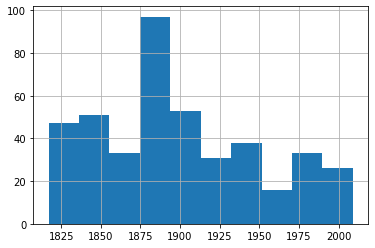

In [11]:
df_sentences['year'].hist()

<AxesSubplot:>

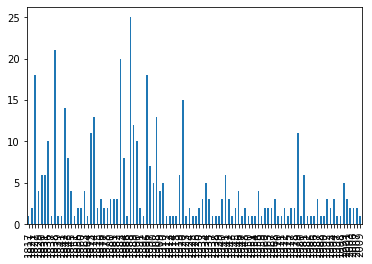

In [12]:
df_sentences['year'].value_counts(sort=False).plot(kind='bar')

In [13]:
df_sentences['time_id'] = ['1' if year <= 1860 else None for year in df_sentences['year']]
df_sentences.loc[df_sentences['year'] >= 1960, 'time_id'] = '2'
df_sentences['time_id'].value_counts(dropna=False)

NaN    254
1      102
2       69
Name: time_id, dtype: int64

In [14]:
pipeline_embed = pipeline("feature-extraction", 
                    model=model, 
                    tokenizer=tokenizer)

In [15]:
sentences_1 = list(df_sentences[df_sentences.time_id=='1']['sentence'])
sentences_2 = list(df_sentences[df_sentences.time_id=='2']['sentence'])

In [16]:
embeddings_time1 = run_pipeline(pipeline_embed, 
                                sentences_1, 
                                '1')

In [17]:
len(embeddings_time1), len(sentences_1)

(102, 102)

In [18]:
embeddings_time2 = run_pipeline(pipeline_embed, 
                                sentences_2, 
                                '2')

In [19]:
import numpy as np

def get_word_embeddings(pipeline, embedding, sent, query):
    """
    Only retrieve the embeddings for the tokens that match the query
    Does not yet handle the case where query is split up in tokenization.
    """
    token_ids = pipeline.tokenizer(sent, time_id='1')
    tokens = pipeline.tokenizer.convert_ids_to_tokens(token_ids['input_ids'])
    query_embeddings = np.array([embedding[i] for i,tok in enumerate(tokens) if tok==query])
    return list(query_embeddings)

In [20]:
embeddings_time1

In [ ]:

# df_embeddings = pd.DataFrame()
# time1_idx = 0
# time2_idx = 0

# for _, row in tqdm(df_sentences.iterrows()):
#     if row['time_id'] == '1':
#         emb = get_word_embeddings(pipeline_embed, embeddings_time1[time1_idx], row['sentence'], term)
#         time1_idx +=1
#     elif row['time_id'] == 2:
#         emb = get_word_embeddings(pipeline_embed, embeddings_time2[time2_idx], row['sentence'], term)
#         time2_idx +=1
#     else:
#         emb = None
#     df_embeddings = df_embeddings.append(pd.DataFrame({
#         'sentence': row['sentence'],
#         'year': row['year'],
#         'genre': row['genre'],
#         'id': row['id'],
#         'embedding': emb}))

0it [00:00, ?it/s]


In [ ]:
df_embeddings.head()